# Mitigating Unfairness in the Law School Dataset

In this example, we will examine the well known Law School Admissions dataset, provided by [Project SEAPHE](http://www.seaphe.org/databases.php). The motivation was to gain a better understanding of race in law school admissions, and ensuring that students who would ultimately pass the bar exam were treated fairly.

## Obtaining the Data

We obtain the data from the `tempeh` package. The main feature data (which we will refer to as $X$) has two features - undergraduate GPA and LSAT score. The label (which we call $y$) is 0 or 1 dependent on whether that student passed the bar exam. Finally, we also have the race of the students ('black' or white') as a sensitive attribute, which we will refer to as $A$.

We start by loading the data, which have already been split into "train" and "test" subsets for us. However, we do need to rescale the two features in $X$ to lie in the range $[0, 1]$:

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from tempeh.configurations import datasets
dataset = datasets['lawschool_passbar']()

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset.X_train), columns=dataset.features)
X_test = pd.DataFrame(scaler.fit_transform(dataset.X_test), columns=dataset.features)

y_train = pd.Series(dataset.y_train.squeeze(), name="Pass Bar")
y_test = pd.Series(dataset.y_test.squeeze(), name="Pass Bar")

A_train = pd.Series(dataset.race_train, name="Race")
A_test = pd.Series(dataset.race_test, name="Race")

No module named 'torch'. If you want to use pytorch with tempeh please install pytorch separately first.
No modules named 'keras' and 'tensorflow'. If you want to use keras and tensorflow with tempeh please install keras and tensorflow separately first.


Now, let us examine the data. First, we can look at the breakdown of students by race in the dataset. We see that there are far more white students than black, which is already a suggestion of bias in the data:

In [2]:
l, c = np.unique(dataset.race_train, return_counts=True)
for i in range(len(l)):
    print("Number of {0} students is {1}".format(l[i], c[i]))

Number of black students is 880
Number of white students is 12828


We can also start using the group metrics from `fairlearn` to examine things such as the final pass rate for the bar exam. Both rates are high, although higher for whites:

In [3]:
from fairlearn.metrics import group_mean_prediction

def group_metric_printer(name, group_metric_result):
    print("{0} overall {1:.3f}".format(name, group_metric_result.overall))
    for k, v in group_metric_result.by_group.items():
        print("{0} for {1:8} {2:.3f}".format(name, k, v))

unused = np.ones(len(dataset.y_train))
group_metric_printer("Pass Rate", group_mean_prediction(unused, y_train, A_train))

Pass Rate overall 0.956
Pass Rate for black    0.781
Pass Rate for white    0.968


We can also examine the [ROC-AUC scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for each feature (that is LSAT score and undergraduate GPA) for the overall dataset and by race. Used in this way, the ROC-AUC score is a measure of how predictive each feature is of the final label. A score of 0.5 would mean that the feature is no better than a coin flip (a coin biased to produce a desired fraction of positives), while a score of 1 means that the feature is perfectly discriminating:

In [5]:
from fairlearn.metrics import group_roc_auc_score

for column_name in X_train:
    column_data = X_train[column_name]
    title = "ROC-AUC {0}".format(column_name)
    group_metric_printer(title, group_roc_auc_score(y_train, column_data, A_train))

ROC-AUC lsat overall 0.745
ROC-AUC lsat for black    0.694
ROC-AUC lsat for white    0.684
ROC-AUC ugpa overall 0.680
ROC-AUC ugpa for black    0.605
ROC-AUC ugpa for white    0.637


We can also examine the CDFs for the LSAT and GPAs for whites and blacks (recall that we rescaled both to $[0,1]$ above):

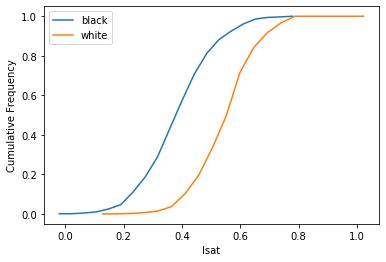

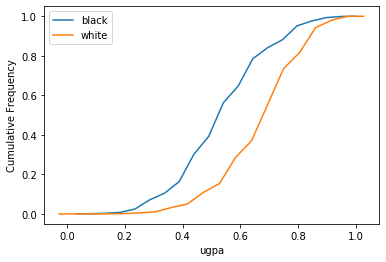

In [31]:
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

def plot_separated_cdf(data, A):
    for a in np.unique(A):
        subset = data[A==a]
        
        cdf = cumfreq(subset, numbins=20)
        x = cdf.lowerlimit + np.linspace(0, cdf.binsize*cdf.cumcount.size, cdf.cumcount.size)
        plt.plot(x, cdf.cumcount / len(subset), label=a)
    plt.xlabel(data.name)
    plt.ylabel("Cumulative Frequency")
    plt.legend()
    plt.show()
        

plot_separated_cdf(X_train['lsat'], A_train)
plot_separated_cdf(X_train['ugpa'], A_train)

## An Unmitigated Predictor

As a point of comparison for later, we can train a predictor without regard to fairness.

In [ ]:
unmitigated_predictor = LogisticRegression(solver='liblinear', fit_intercept=True)

unmitigated_predictor.fit(dataset.X_train, dataset.y_train)

With this predictor, we can look at some statistics. First, we examine the normal error and disparity metrics one might expect

In [ ]:
y_pred_unmitigated = unmitigated_predictor.predict_proba(dataset.X_test)[:,1]
print(y_pred_unmitigated)

from fairlearn.metrics import group_zero_one_loss, group_mean_prediction

# unmitigated_zero_one_loss = group_zero_one_loss(dataset.y_test, y_pred_unmitigated, dataset.race_test)
unmitigated_mean_prediction = group_mean_prediction(dataset.y_test, y_pred_unmitigated, dataset.race_test)

#print("Zero One Loss Overall {0:.3f}".format(unmitigated_zero_one_loss.overall))
#print("Zero One Loss whites  {0:.3f}".format(unmitigated_zero_one_loss.by_group['white']))
#print("Zero One Loss blacks  {0:.3f}".format(unmitigated_zero_one_loss.by_group['black']))
print()
print("Mean Prediction Overall {0:.3f}".format(unmitigated_mean_prediction.overall))
print("Mean Prediction whites  {0:.3f}".format(unmitigated_mean_prediction.by_group['white']))
print("Mean Prediction blacks  {0:.3f}".format(unmitigated_mean_prediction.by_group['black']))

The high general pass rate is obviously causing problems, since this predictor is giving a 100% pass rate for whites and only causing a small error as a result. The disparity (the difference in the mean prediction for blacks and whites) is also very small for similar reasons.

With such unbalanced classes, it is better to use `group_balanced_root_mean_squared_error` to track disparity, since this puts equal weight on over- and under-predictions, regardless of the relative number of either. Similarly, the error is best tracked via the `group_roc_auc_score`:

In [ ]:
from fairlearn.metrics import group_roc_auc_score, group_balanced_root_mean_squared_error

print(roc_auc_score(dataset.y_test, y_pred_unmitigated))
print(unmitigated_predictor.coef_)
print(y_pred_unmitigated)

unmitigated_group_roc_auc_score = group_roc_auc_score(dataset.y_test, y_pred_unmitigated, dataset.race_test)
print("roc white", unmitigated_group_roc_auc_score.by_group['white'])
print("roc black", unmitigated_group_roc_auc_score.by_group['black'])
print("Unmitigated Error {0:.3f}".format(1 - unmitigated_group_roc_auc_score.maximum))

unmitigated_group_balanced_rms_error = group_balanced_root_mean_squared_error(dataset.y_test, y_pred_unmitigated, dataset.race_test)
print("Unmitigated Disparity {0:.3f}".format(unmitigated_group_balanced_rms_error.range))

## Doing a Grid Search

We do a grid search in two stages. In the first, we do a low resolution search, with `fairlearn` chosing the grid for us. From this, we identify a region to expand the grid, and do a more detailed sweep around that point.

First the low resolution sweep:

In [ ]:
n_sweep = 9
sweep = GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                   constraints=DemographicParity(),
                   grid_size=n_sweep)

sweep.fit(dataset.X_train, dataset.y_train, sensitive_features=dataset.race_train)

print(sweep.best_result.lambda_vec)

Extract the best $\lambda$ value:

In [ ]:
lambda_vec_best = sweep.best_result.lambda_vec
lambda_best = lambda_vec_best[("+", "all", "white")] - lambda_vec_best[("-", "all", "white")]
print("lambda_best =", lambda_best)

Create a higher resolution grid:

In [ ]:
n_second_sweep = 51
second_sweep_multipliers = np.linspace(lambda_best-0.5, lambda_best+0.5, n_second_sweep)

iterables = [['+','-'], ['all'], ['black', 'white']]
midx = pd.MultiIndex.from_product(iterables, names=['sign', 'event', 'group_id'])

second_sweep_lambdas = []
for l in second_sweep_multipliers:
    nxt = pd.Series(np.zeros(4), index=midx)
    if l < 0:
        nxt[("-", "all", "white")] = abs(l)
    else:
        nxt[("+", "all", "white")] = l
    second_sweep_lambdas.append(nxt)
    
multiplier_df = pd.concat(second_sweep_lambdas, axis=1)

Perform the new search

In [ ]:
second_sweep = GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                   constraints=DemographicParity(),
                   grid=multiplier_df)

second_sweep.fit(dataset.X_train, dataset.y_train, sensitive_features=dataset.race_train)

Now we can do some analysis.

### Naive Analysis

We can look at our results using the zero-one loss and mean prediction metrics. These are not very useful, as we shall see:

In [ ]:
sweep_naive_error = np.zeros(n_second_sweep)
sweep_naive_disparity = np.zeros(n_second_sweep)

for i in range(n_second_sweep):
    preds = second_sweep.all_results[i].predictor.predict_proba(dataset.X_test)[:,1]
    sweep_naive_error[i] = group_roc_auc_score(dataset.y_test, preds, dataset.race_test).maximum
    sweep_naive_disparity[i] = group_mean_prediction(dataset.y_test, preds, dataset.race_test).range
    
plt.scatter(sweep_naive_error, sweep_naive_disparity)
plt.xlabel("Error")
plt.ylabel("Disparity")
plt.show()

### Using Alternative Metrics

As noted above, it is better to use the `group_roc_auc_score` metric for the error, and the `group_balanced_root_mean_squared_error` for disparity. With these metrics, we find:

In [ ]:
sweep_error = np.zeros(n_second_sweep)
sweep_disparity = np.zeros(n_second_sweep)

for i in range(n_second_sweep):
    preds = second_sweep.all_results[i].predictor.predict_proba(dataset.X_test)[:,1]
    sweep_error[i] = group_roc_auc_score(dataset.y_test, preds, dataset.race_test).overall
    sweep_disparity[i] = group_balanced_root_mean_squared_error(dataset.y_test, preds, dataset.race_test).range
    
plt.scatter(sweep_error, sweep_disparity)
plt.xlabel("ROC AUC Score")
plt.ylabel("Disparity")
plt.show()

We can also look at how the predictions are varying with the set of generated Lagrange multipliers. What we see is that we are gradually moving to predict that all students pass the bar.

In [ ]:
mean_predictions = [group_mean_prediction(dataset.y_test, x.predictor.predict_proba(dataset.X_test)[:,1], dataset.race_test)
                   for x in second_sweep.all_results]

for r in ['black', 'white']:
    plt.scatter(second_sweep_multipliers, [x.by_group[r] for x in mean_predictions], label=r)
plt.xlabel("Multiplier")
plt.ylabel("Opportunity")
plt.legend()
plt.show()